Clipping DEM/ICESat-2 data using polygons (GLIMS data)

In [1]:
# !pip install -e Assimilation

%load_ext autoreload
%autoreload 2

1. Reading DEM and ICESat-2 data



In [21]:
from simlib.coregistration import reference_dem
from simlib import atl06lib
import glob
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import dask.dataframe as dd

%matplotlib inline

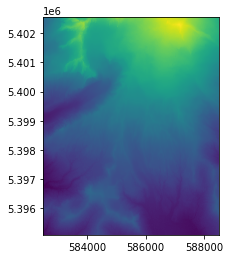

In [14]:
dem_path = '/srv/shared/data-knuth/reference_dem_clip.tif'
dem = reference_dem(dem_path)
dem.show()

[autoreload of simlib.atl06lib failed: Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/srv/conda/envs/notebook/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/srv/conda/envs/notebook/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/jovya

Number of points: 894


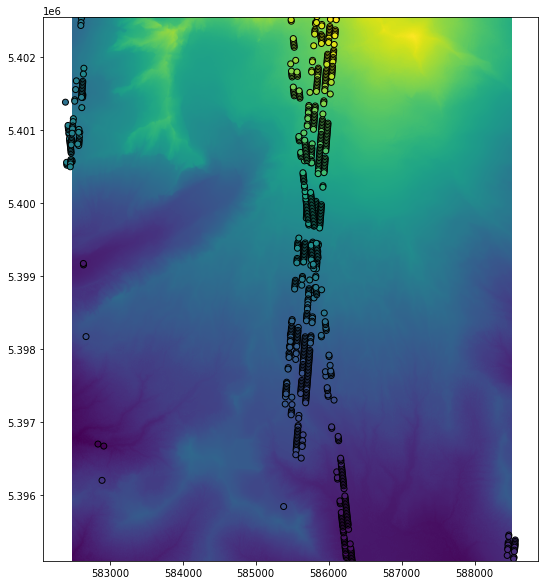

In [50]:
is2_paths = glob.glob('/home/jovyan/data/ICESat-2_Baker_Processed/*.h5')
# is2_paths = glob.glob('/srv/shared/data-whyjay/ICESat-2_Baker_Processed/*.h5')

# Variables we want to plot
vnames = ['x', 'y', 'h_li']
# List with one dataframe per file
is2_dds = [dd.from_array(atl06lib.read_h5(f, vnames), columns=vnames) for f in is2_paths]
is2_dd = dd.concat(is2_dds)
is2_ddf = is2_dd.compute()
is2_gpd = gpd.GeoDataFrame(is2_ddf, geometry=gpd.points_from_xy(is2_dd['x'], is2_dd['y']), crs='EPSG:' + dem.epsg)

print('Number of points:', len(is2_gpd))

fig,ax = plt.subplots(1,figsize=(10,10))
dem.show(ax=ax)
is2_gpd.plot(ax=ax, column='h_li', edgecolor='black')


2. Reading GLIMS data at baker

(5395092.518148141, 5402543.276693823)

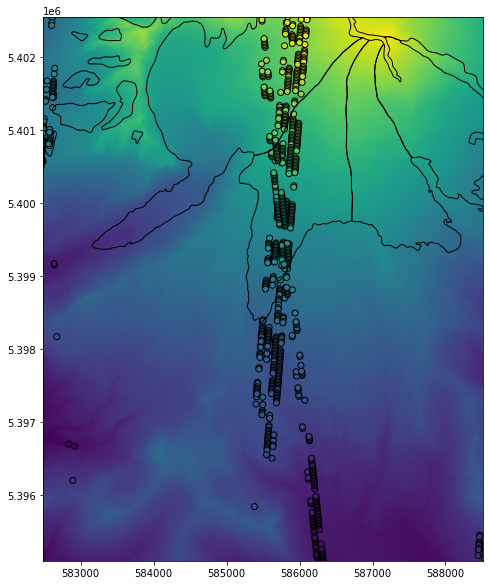

In [48]:
glims_path = '/srv/shared/data-whyjay/glims_mtBaker/glims_polygons.shp'
shapefile = gpd.read_file(glims_path)

shapefile['geometry'] = shapefile['geometry'].to_crs(epsg=int(dem.epsg))

fig,ax = plt.subplots(1,figsize=(10,10))
dem.show(ax=ax)
is2_gpd.plot(ax=ax, column='h_li', edgecolor='black')
shapefile.plot(ax=ax, facecolor="none", edgecolor='black')
ax.set_xlim([dem.x.min(), dem.x.max()])
ax.set_ylim([dem.y.min(), dem.y.max()])


3. Apply the points-in-polygon algorithm and add a column "on_ice" (value = 1 or 0) to IS2 gpd array

In [ ]:
dem.create_bare_rock_mask(method='RGI', polygon_shapefile=glims_path)